## Loading packages

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import ast

# Loading own functions
from minibatches import create_mini_batches
from plots import plots_performance
from conf_matrix import conf_matrix
from load_data import data_loading
from model import model_setup
from top_pred import topology_prediction
from confidence_plot import confidence_plot

## Loading data, functions and model setup

In [10]:
# Loading the data
train_set, val_set, test_set = data_loading()

# Defining model to load 
load_model = '/Users/Christina/Desktop/lr_0.01_crf_True_batch_32_epochs_1000_model/'

if load_model[-1] == '/':
    load_model = load_model[:-1]

In [11]:
# Defining the optimal hyperparameter settings
model_info = load_model.split('/')[-1].split('_')

learning_rate = float(model_info[1])
CRF = ast.literal_eval(model_info[3])
batch_size = int(model_info[5])
n_hidden = 60

## Loading the model and testing

In [12]:
# Setting up the model
tf.reset_default_graph()
X_pl, mask_pl, y_pl, len_pl, y_type_pl, train_op, y_seq, y_seq_conf, y_type_pred, y_type_conf, loss, accuracy_seq, accuracy_type, transition_params = model_setup(learning_rate = learning_rate, n_hidden = n_hidden, CRF = CRF)

# Restore and load model
with tf.Session() as sess:
    try:
        
        print('Started testing.')
        
        saver = tf.train.Saver()
        saver.restore(sess, load_model + '/model')

        
        ### Testing the model

        # Loading the test set
        batches_X, batches_y, batches_mask, batches_y_type, batches_len = create_mini_batches(test_set, batch_size)

        # Setting up result lists
        true_seq, true_type, pred_seq, pred_type, pred_seq_acc, pred_type_acc, \
        pred_seq_conf, pred_type_conf = [], [], [], [], [], [], [], []

        # Looping over minibatches and training on each one
        for batch in range(len(batches_X)):

            # Make fetches
            fetches_test = [y_seq, y_type_pred, accuracy_seq, accuracy_type, \
                            y_seq_conf, y_type_conf, transition_params] 
            
            # Set up feed dict (to feed the network with test data)
            feed_dict_test = {X_pl: batches_X[batch], mask_pl: batches_mask[batch], \
                              y_pl: batches_y[batch], y_type_pl: batches_y_type[batch], \
                              len_pl: batches_len[batch]}

            # Run the model and append the results to lists
            res_test = sess.run(fetches = fetches_test, feed_dict = feed_dict_test)
            
            pred_seq.extend([seq[batches_mask[batch][i].astype(bool)] for i, seq in enumerate(res_test[0])]) 
            pred_type.extend(res_test[1])
            pred_seq_acc.append(res_test[2])
            pred_type_acc.append(res_test[3])
            pred_seq_conf.extend(res_test[4])
            pred_type_conf.extend(res_test[5])
            
            true_seq.extend([batches_y[batch][j][batches_mask[batch][j].astype(bool)] for j in range(len(batches_y[batch]))])          
            true_type.extend(batches_y_type[batch])    
    
    except KeyboardInterrupt:
        pass
            
print('Done testing.')

/Users/Christina/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Started testing.
INFO:tensorflow:Restoring parameters from /Users/Christina/Desktop/lr_0.01_crf_True_batch_32_epochs_1000_model/model
Done testing.


# Results
## Accuracies for predictions

In [13]:
print('The average accuracy for prediction of amino acid locations: {0:.2f} %'.format(np.mean(pred_seq_acc) * 100))
print('The average accuracy for prediction of type: {0:.2f} %'.format(np.mean(pred_type_acc) * 100))

The average accuracy for prediction of amino acid locations: 93.88 %
The average accuracy for prediction of type: 96.57 %


## Confusion matrices for predictions 1 + 2

The actual class is in the rows and predicted class is in the columns.

In [14]:
conf_matrix(true_seq, pred_seq, true_type, pred_type)

Confusion matrix for classification of amino acid location
           In->Out    Out->In    SP         Inside     Outside   
In->Out    1818       636        94         915        1602      
Out->In    874        3672       77         929        2375      
SP         9          0          12673      493        697       
Inside     431        254        205        385495     14676     
Outside    559        558        303        8950       206515    

Confusion matrix for classification of proteins
           TM         SP+TM      SP+Glob    Glob      
TM         47         7          4          4         
SP+TM      4          130        6          3         
SP+Glob    0          1          423        10        
Glob       0          0          7          699       

Confusion matrix for classification of proteins in percent
           TM         SP+TM      SP+Glob    Glob      
TM         75.81      11.29      6.45       6.45      
SP+TM      2.80       90.91      4.20       2.10   

## Confidence for topology prediction

In [15]:
topology_prediction(true_seq, pred_seq, true_type, pred_type) 

Topology prediction results:
           TM         SP+TM      Glob+SP    Glob      
Correct    6.45       61.54      97.47      99.01     
Wrong top  69.35      29.37      -          -         


## For models with CRF, look at transition matrix

In [16]:
if CRF == True:
    print('Transition matrix:')
    print(res_test[6])

Transition matrix:
[[  2.59557295 -26.45238304 -22.12199783 -21.08243179   4.16291428]
 [-24.64021301   2.53751945 -19.53077888   4.47754431  -5.35449886]
 [-23.29758072 -30.41456032   2.20561671 -10.6401329   -2.37029099]
 [ -8.01643944 -34.59097672 -30.40345955   2.31676817 -27.09503365]
 [-32.9541626   -9.1465826  -25.92239952 -27.46617317   1.966699  ]]


## Visualization of the prediction for a single protein

The predicted type of this protein is "Transmembrane". The confidence for the type prediction is 99.25 %.
The true type is "Transmembrane".


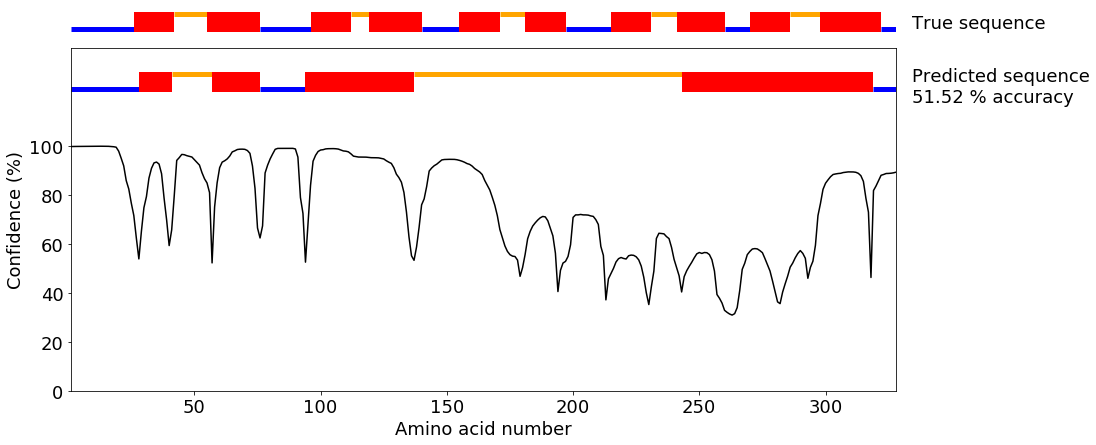

In [24]:
# Get a single protein (we just made it for a random one here)
i = 436 # Change here for another example

confidence_plot(pred_seq[i], true_seq[i], pred_seq_conf[i], pred_type[i], true_type[i], pred_type_conf[i], len(true_seq[i]))